# Simulation d'une source constante sauf une année

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [3]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [4]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [5]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

# for consistency we will use the template using exp cutoff for both the central source and the DE
# but it will generally require that the cutoff of the DE be frozen and set to infinity (lambda = 0)

model_name = pathmo/"models_template_2cutoff.yaml" 

pathres = Path(path/"simu_variable")
pathres.mkdir(exist_ok=True)

# Début de l'analyse (avec mapdatasets déjà écrits)

## Création de la géométrie

In [6]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## Creating the datasets

In [7]:
datasets_year = Datasets.read(pathma/"datasets_year.yaml")

## Reading the model template

In [8]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [9]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 2.12e-12

modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.77

modelGC.spectral_model.parameters['lambda_'].frozen = True
modelGC.spectral_model.parameters['lambda_'].value = 1/5.4

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 6.09e-12

modeldiff.parameters["index"].frozen = True
modeldiff.parameters["index"].value = 2.24

modeldiff.spectral_model.parameters['lambda_'].frozen = True
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

In [10]:
modelGCnaive, modeldiffnaive = modelGC.copy(), modeldiff.copy()

modelGCnaive.parameters["amplitude"].value = 3e-12
modeldiffnaive.parameters["amplitude"].value = 5e-12

## Constructing the mask

In [11]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

# Ajustement du modèle aux cartes

In [12]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    #cov = result.parameters.covariance
    
    return table, result# , cov

# Ajustement des données simulées

In [17]:
%%time

emin = 1.0*u.TeV
emax = 10*u.TeV

GCflux_distribution = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }
DEflux_distribution = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }

for iter in range(2):
    for year in range(2009,2010):
        # données simulées
        datasets_year[f'map_{year}'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy()]
        datasets_year[f'map_{year}'].fake() # ça renvoie les mêmes résultats à chaque fois...
        
        # on remet les modèles
        datasets_year[f'map_{year}'].fit_mask = fit_mask
        bkg_model = FoVBackgroundModel(dataset_name=f"map_{year}")
        datasets_year[f'map_{year}'].models =  [modelGCnaive.copy(),modelG09.copy(),modeldiffnaive.copy(),bkg_model]

        # on fait le fit
        table, result = fit_dataset(datasets_year[f"map_{year}"])
        print(datasets_year[f"map_{year}"])
        
        diffuse_flux = datasets_year[f'map_{year}'].models[2].spectral_model.integral(emin, emax)
        GC_flux = datasets_year[f'map_{year}'].models[0].spectral_model.integral(emin, emax)
        
        GCflux_distribution[year].append(GC_flux)
        DEflux_distribution[year].append(diffuse_flux)

MapDataset
----------

  Name                            : map_2009 

  Total counts                    : 3936 
  Total background counts         : 3713.61
  Total excess counts             : 222.39

  Predicted counts                : 3943.90
  Predicted background counts     : 3672.88
  Predicted excess counts         : 271.02

  Exposure min                    : 5.24e+07 m2 s
  Exposure max                    : 2.65e+09 m2 s

  Number of total bins            : 4000000 
  Number of fit bins              : 747650 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 39306.67

  Number of models                : 4 
  Number of parameters            : 20
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : meqtS77P
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      

In [16]:
datasets_year['map_2009'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy()]
datasets_year['map_2009'].fake() # ça renvoie les mêmes résultats à chaque fois...
print(datasets_year['map_2009'])

datasets_year['map_2009'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy()]
datasets_year['map_2009'].fake() # ça renvoie les mêmes résultats à chaque fois...
print(datasets_year['map_2009'])

MapDataset
----------

  Name                            : map_2009 

  Total counts                    : 3980 
  Total background counts         : 3713.61
  Total excess counts             : 266.39

  Predicted counts                : 3946.86
  Predicted background counts     : 3713.61
  Predicted excess counts         : 233.25

  Exposure min                    : 5.24e+07 m2 s
  Exposure max                    : 2.65e+09 m2 s

  Number of total bins            : 4000000 
  Number of fit bins              : 747650 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 39309.92

  Number of models                : 3 
  Number of parameters            : 17
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : jOOBEY53
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      

In [19]:
GCflux_distribution

{2004: [<Quantity 1.50027698e-12 1 / (cm2 s)>,
  <Quantity 1.50027698e-12 1 / (cm2 s)>],
 2005: [],
 2006: [],
 2007: [],
 2008: [],
 2009: [],
 2010: [],
 2011: [],
 2012: [],
 2013: [],
 2014: [],
 2015: [],
 2016: [],
 2017: [],
 2018: [],
 2019: []}

In [43]:
# we automatically exclude the years for which the fit didn't succeed (should be the same for all datasets here)

years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

# Saving the results

In [ ]:
# for each year we will store the pvalue computed for a constant model, 
# knowing that for this year the intrinsic flux is 10%, 20%, 30%, 50% higher than the others years (effectively constant in terms of intrinsic flux)

pvalue_dict = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
               2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
               2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }

In [ ]:
for i in range(4):
    for year in years:
        
        

## Time evolution of the fluxes

In [44]:
def CalculateFluxFromModels(mapdataset, emin, emax):
    models  = mapdataset.models
    
    amplitudeGC = models[0].spectral_model.parameters['amplitude'].value
    amp_errGC = models[0].spectral_model.parameters['amplitude'].error
    
    amplitudediff = models[2].spectral_model.parameters['amplitude'].value
    amp_errdiff = models[2].spectral_model.parameters['amplitude'].error
    
    #norm = mapdataset.background_model.parameters['norm'].value
    #norm_err = mapdataset.background_model.parameters['norm'].error
    
    if isinstance(emin, u.Quantity):

        diffuse_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)

    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff#, norm, norm_err

In [45]:
# Extracting parameters from each years fitted model

emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
#norms = []
#norms_err = []


for year in years:
    dif , GC, amp, amp_err, ampdiff, amp_errdiff = CalculateFluxFromModels(datasets_year[f"map_{year}"] , emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    #norms.append(norm)
    #norms_err.append(norm_err)
    
resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)
#norms = np.asarray(norms)
#norms_err = np.asarray(norms_err)

In [46]:
# Errors computation

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff

cross_term = []

#cov_per_year n'existe plus ???
#1,8,13,17

for k,year in zip(range(len(years)),years):
    term = 2*(datasets_year[f"map_{year}"].models.covariance.data[1,13]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    cross_term.append(term)
      
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 - cross_term )

## Fitting a time evolution model

In [24]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

### Evolution of the ratio

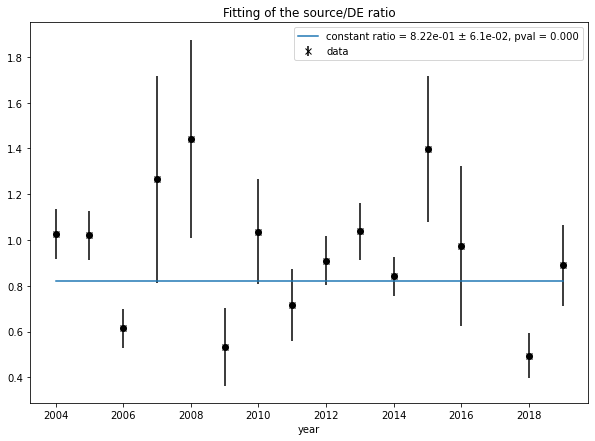

In [27]:
x = years
y = resGC/resdiff
y_uncs = yerr_rap


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = yerr_rap

pv = pval(A1, A2, err_bars, len(A1)-1)

error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant ratio = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Fitting of the source/DE ratio")
plt.savefig(pathres/"LC_ratio_1cut_fr.pdf")

## Model predictions

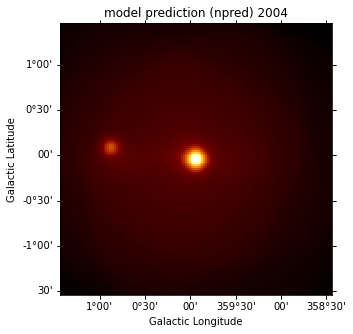

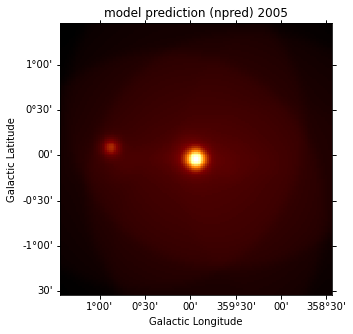

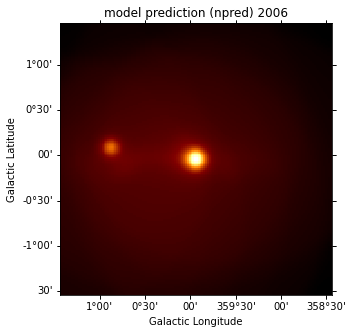

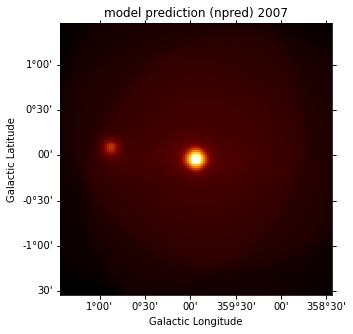

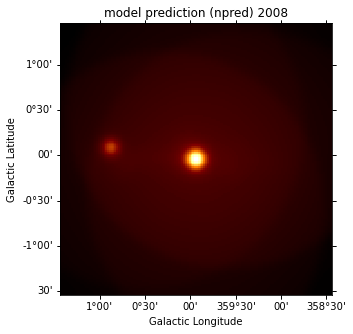

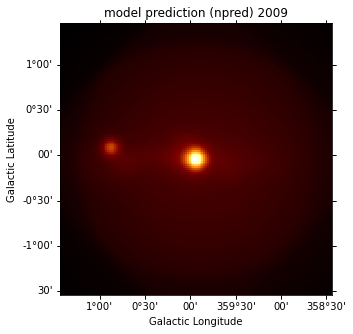

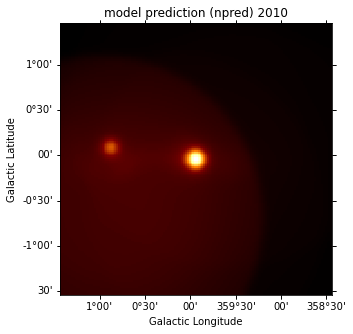

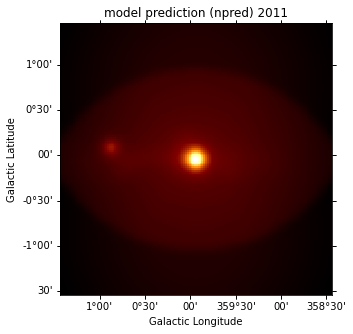

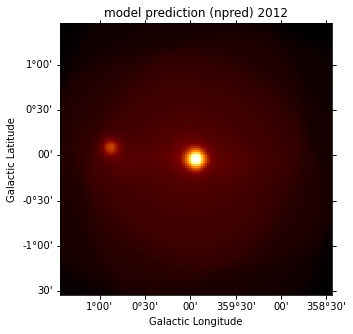

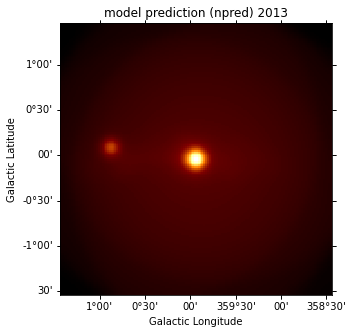

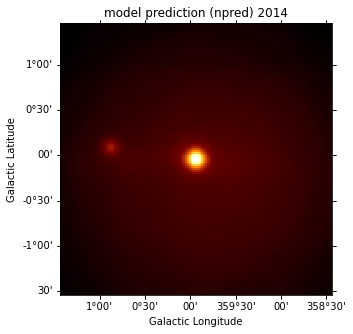

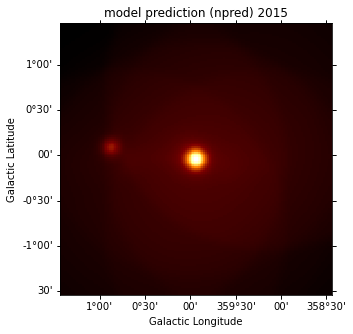

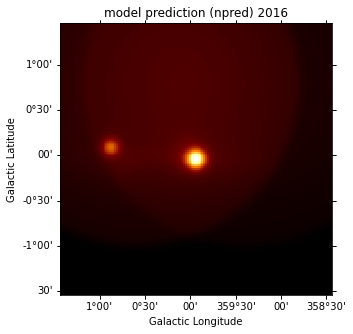

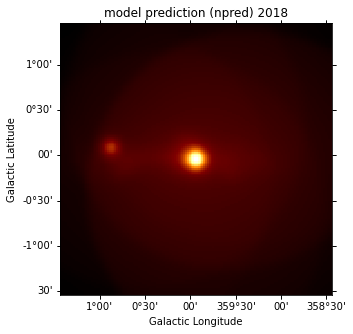

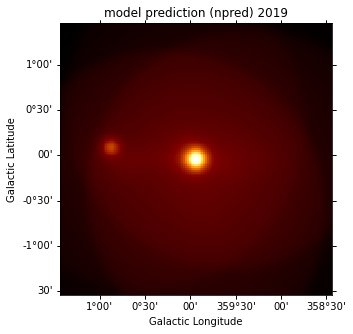

In [28]:
pathm = Path(pathres/"model_maps")
pathm.mkdir(exist_ok=True)

for year in years:
    plt.figure(figsize=(5,5))
    datasets_year[f"map_{year}"].npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
    plt.title("model prediction (npred) " + str(year))
    
    name ="model_"+ str(year)+"_map_fr.pdf"
    plt.savefig(pathm/name)

## Residuals

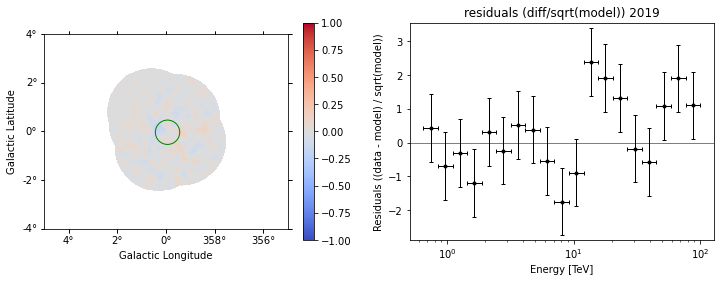

In [32]:
pathr = Path(pathres/"residuals")
pathr.mkdir(exist_ok=True)

kwargs_spatial = {'vmin':-1, 'vmax':1 } # nécessaire ?

kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)}


for year in years:

    datasets_year[f"map_{year}"].plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    name = "residuals_"+str(year)+"_fr_full.pdf"
    plt.title("residuals (diff/sqrt(model)) " + str(year))
    plt.savefig(pathr/name, overwrite=True)

## Significance

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/a

CPU times: user 1min 38s, sys: 22.5 s, total: 2min 1s
Wall time: 1min 53s


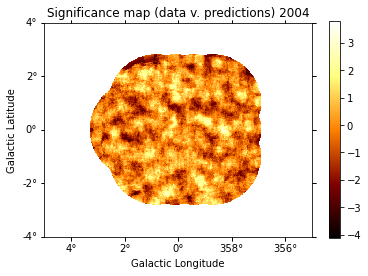

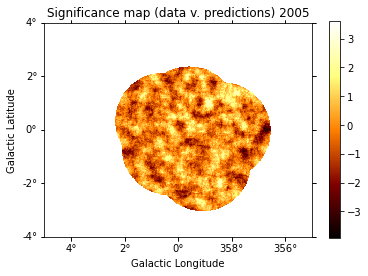

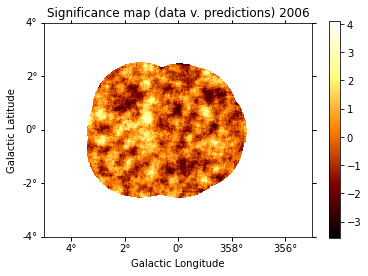

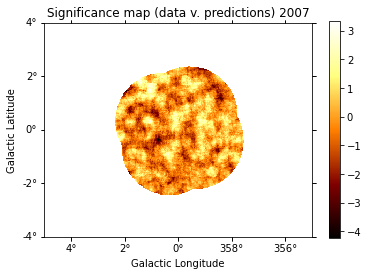

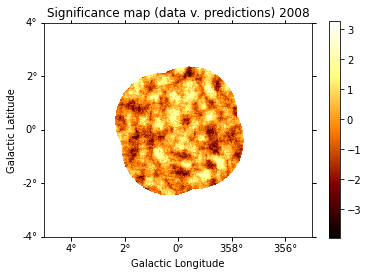

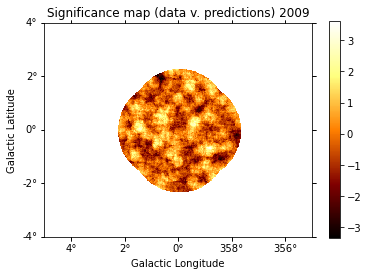

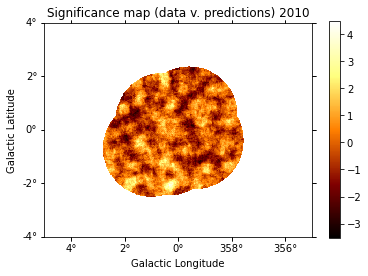

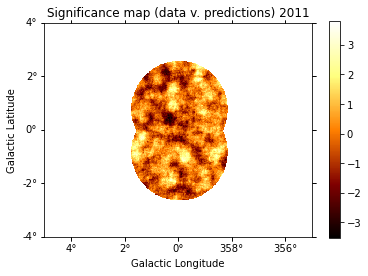

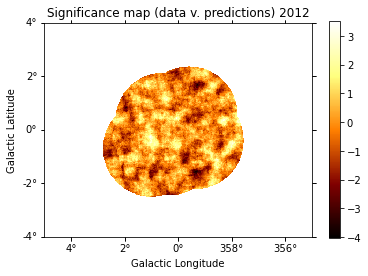

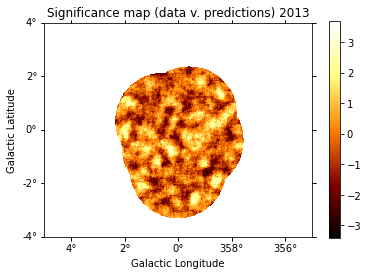

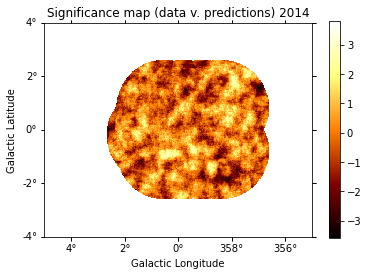

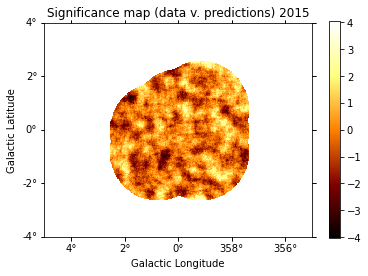

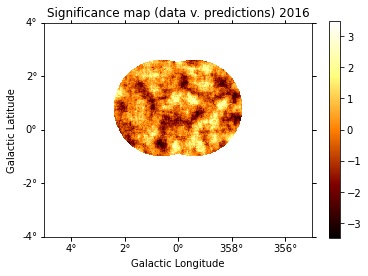

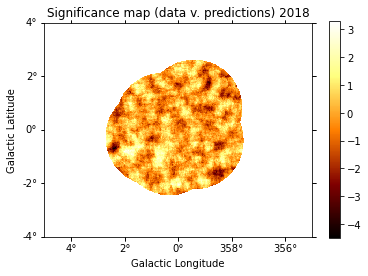

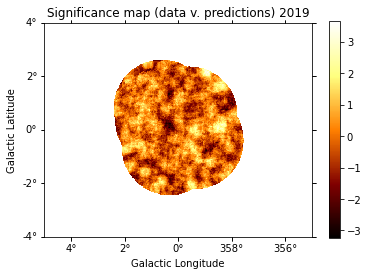

In [30]:
%%time
#très long ?

paths = Path(pathres/"significance")
paths.mkdir(exist_ok=True)

lima_significances = dict()

for year in years:
    plt.figure()

    lima_estimator = ExcessMapEstimator("0.2 deg", selection_optional=[] )
    
    lima_significances[year] = lima_estimator.run(datasets_year[f"map_{year}"])
    
    lima_significances[year]['sqrt_ts'].plot(add_cbar=True)
    name = "significance_"+str(year)+"_fr_full.pdf"
    
    plt.title("Significance map (data v. predictions) "+str(year))
    plt.savefig(paths/name, overwrite=True)

### Significance distributions

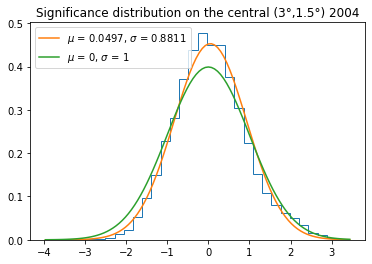

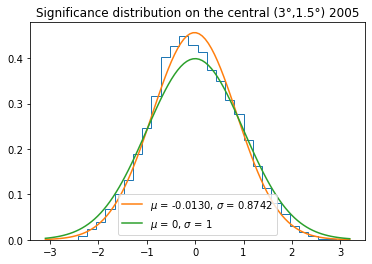

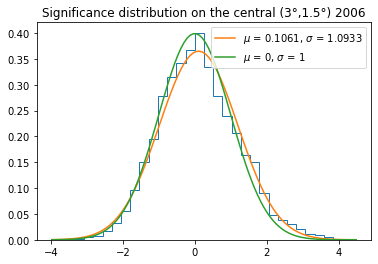

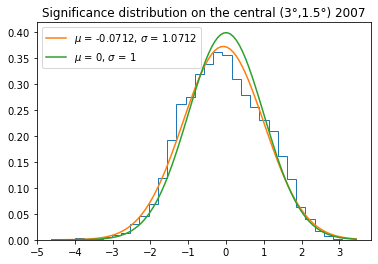

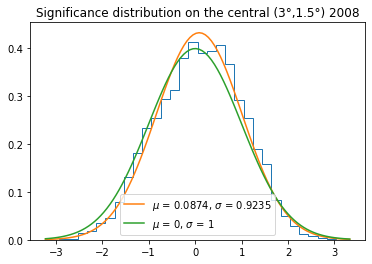

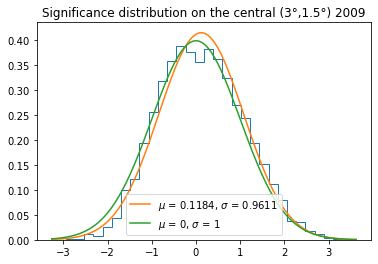

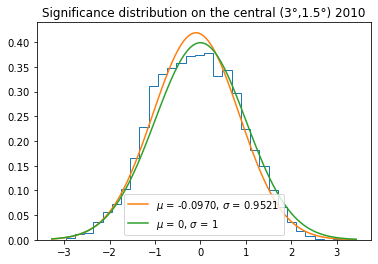

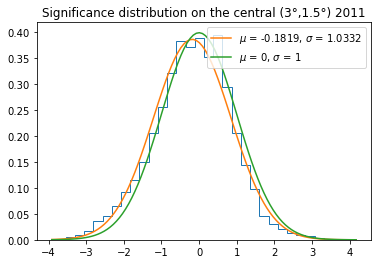

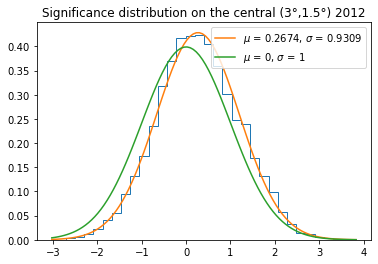

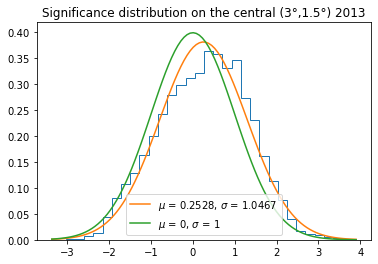

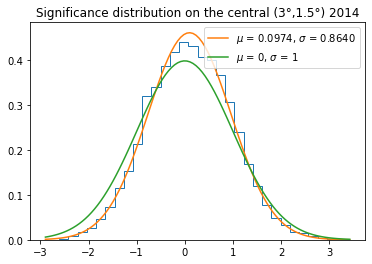

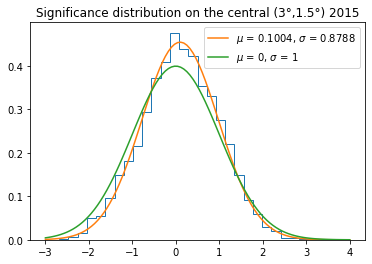

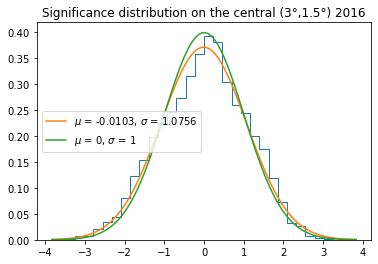

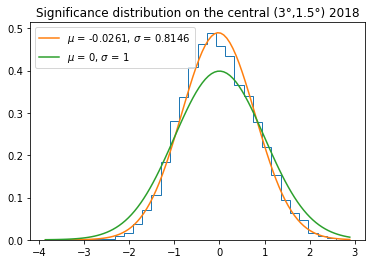

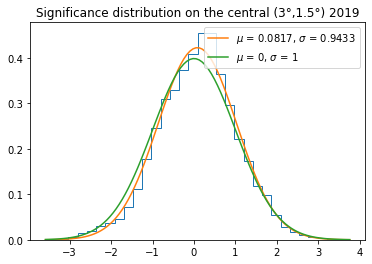

In [31]:
from scipy.stats import norm

pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    signidata = lima_significances[year]['sqrt_ts'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    plt.hist(signidata[0,mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[0,mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist"+str(year)+"_fr_full.pdf"
    plt.title("Significance distribution on the central (3°,1.5°) "+str(year))
    plt.savefig(pathh/name, overwrite=True)